In [1]:
from numba import jit

import lightgbm as lgb
import pandas as pd
import numpy as np

from datetime import datetime
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import FastICA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import pickle

In [2]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('data/train.csv').drop("ID_code",axis=1)
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.shape, df_test.shape

((200000, 201), (200000, 201))

In [4]:
df_train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [5]:
df_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
param = {
   "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 10,
    "verbosity" : 1,
}

In [7]:
# X_train = df_train.copy()
# X_train.drop('target', axis=1, inplace=True)

In [8]:
# X_train['new_f'] = X_train.abs().sum(axis=1) - X_train.sum(axis=1)

In [9]:
# df_train_gauss = pd.read_csv('data/train_gauss.csv')
# df_test_gauss = pd.read_csv('data/test_gauss.csv')

In [68]:
cat_features = ['var_12','var_13','var_108','var_126','var_68']
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]

X, y = df_train[features], df_train.target
X_kaggle_test = df_test[features]

# X['cluster'] = df_train_gauss.cluster
# X['logL'] = df_train_gauss.logL
# X_kaggle_test['cluster'] = df_test_gauss.cluster
# X_kaggle_test['logL'] = df_test_gauss.logL

In [61]:
X.shape, X_kaggle_test.shape

((200000, 200), (200000, 200))

In [69]:
def decode_cat_features(data, cat_features):
    for f in cat_features:
        hist, bin_edges = np.histogram(data[f].values, bins=1000, density=True)
        data['test_' + f] = [hist[np.searchsorted(bin_edges, elem) - 1] for elem in data[f].values]
        
# hardcoded these features. took them from feature importance below
# https://www.kaggle.com/allunia/santander-customer-transaction-eda
def add_bins(data):
    encoder = LabelEncoder()
    for feature in top_features:
        data[feature + "_qbinned"] = pd.qcut(
            X.loc[:, feature].values,
            q=10,
            labels=False
        )
        data[feature + "_qbinned"] = encoder.fit_transform(
            data[feature + "_qbinned"].values.reshape(-1, 1)
        )
        
    
        
def add_rounding(data):
    for feature in top_features:
        data[feature + "_rounded"] = np.round(data.loc[:, feature].values)
        data[feature + "_rounded_10"] = np.round(10*data.loc[:, feature].values)
        data[feature + "_rounded_100"] = np.round(100*data.loc[:, feature].values)

In [13]:
with open('ica.pkl', 'rb') as file:
    transformer = pickle.load(file)

In [25]:
transformer = FastICA(max_iter=5000, tol=0.001, random_state=random_state)
transformer.fit(X)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=5000,
    n_components=None, random_state=42, tol=0.001, w_init=None,
    whiten=True)

In [45]:
with open('ica.pkl', 'wb') as file:
    pickle.dump(transformer, file)

In [62]:
X = transformer.transform(X)
X_kaggle_test = transformer.transform(X_kaggle_test)

X = pd.DataFrame(data=X, columns=df_train[features].columns)
X_kaggle_test = pd.DataFrame(data=X_kaggle_test, columns=df_test[features].columns)

In [70]:
decode_cat_features(X, cat_features)
decode_cat_features(X_kaggle_test, cat_features)
# add_bins(X)
# add_bins(X_kaggle_test)
# add_rounding(X)
# add_rounding(X_kaggle_test)

# X.drop(top_features, axis=1, inplace=True)
# X_kaggle_test.drop(top_features, axis=1, inplace=True)

In [71]:
X.shape, X_kaggle_test.shape

((200000, 205), (200000, 205))

threw out shit with kfold and augmentation

https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87815

says that it's not really needed

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=random_state)

In [73]:
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val)

model = lgb.train(param, train_dataset, 30000, valid_sets=[val_dataset], verbose_eval=200)

[200]	valid_0's auc: 0.864223
[400]	valid_0's auc: 0.873716
[600]	valid_0's auc: 0.880898
[800]	valid_0's auc: 0.885154
[1000]	valid_0's auc: 0.88831
[1200]	valid_0's auc: 0.890892
[1400]	valid_0's auc: 0.892435
[1600]	valid_0's auc: 0.894069
[1800]	valid_0's auc: 0.895379
[2000]	valid_0's auc: 0.896788
[2200]	valid_0's auc: 0.897635
[2400]	valid_0's auc: 0.898444
[2600]	valid_0's auc: 0.899232
[2800]	valid_0's auc: 0.899945
[3000]	valid_0's auc: 0.900582
[3200]	valid_0's auc: 0.900959
[3400]	valid_0's auc: 0.901437
[3600]	valid_0's auc: 0.901891
[3800]	valid_0's auc: 0.902209
[4000]	valid_0's auc: 0.902365
[4200]	valid_0's auc: 0.902594
[4400]	valid_0's auc: 0.902969
[4600]	valid_0's auc: 0.903325
[4800]	valid_0's auc: 0.903437
[5000]	valid_0's auc: 0.903694
[5200]	valid_0's auc: 0.903851
[5400]	valid_0's auc: 0.903874
[5600]	valid_0's auc: 0.90394
[5800]	valid_0's auc: 0.904021
[6000]	valid_0's auc: 0.904221
[6200]	valid_0's auc: 0.904317
[6400]	valid_0's auc: 0.904378
[6600]	valid_0

In [55]:
y_test_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_test_pred)
print('AUC: ', score)

AUC:  0.8928930748560598


In [66]:
y_test_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_test_pred)
print('AUC: ', score)

AUC:  0.8927022945827401


In [37]:
y_test_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_test_pred)
print('AUC: ', score)

AUC:  0.8957612797762086


In [19]:
df_importance = pd.DataFrame()
df_importance['feature'] = X.columns
df_importance['importance'] = model.feature_importance()

In [20]:
df_importance.sort_values(ascending=False, by='importance', inplace=True)

In [21]:
df_importance.head(10)

,feature,importance
199,var_199,1397
64,var_64,1243
68,var_68,1215
94,var_94,1172
108,var_108,1159
166,var_166,1150
131,var_131,1149
193,var_193,1137
154,var_154,1127
88,var_88,1126


In [23]:
n_top = 5
top_features = df_importance.feature.values[:n_top]
top_features_idx = df_importance.index.values[:n_top]
top_features, top_features_idx

(array(['var_199', 'var_64', 'var_68', 'var_94', 'var_108'], dtype=object),
 array([199,  64,  68,  94, 108]))

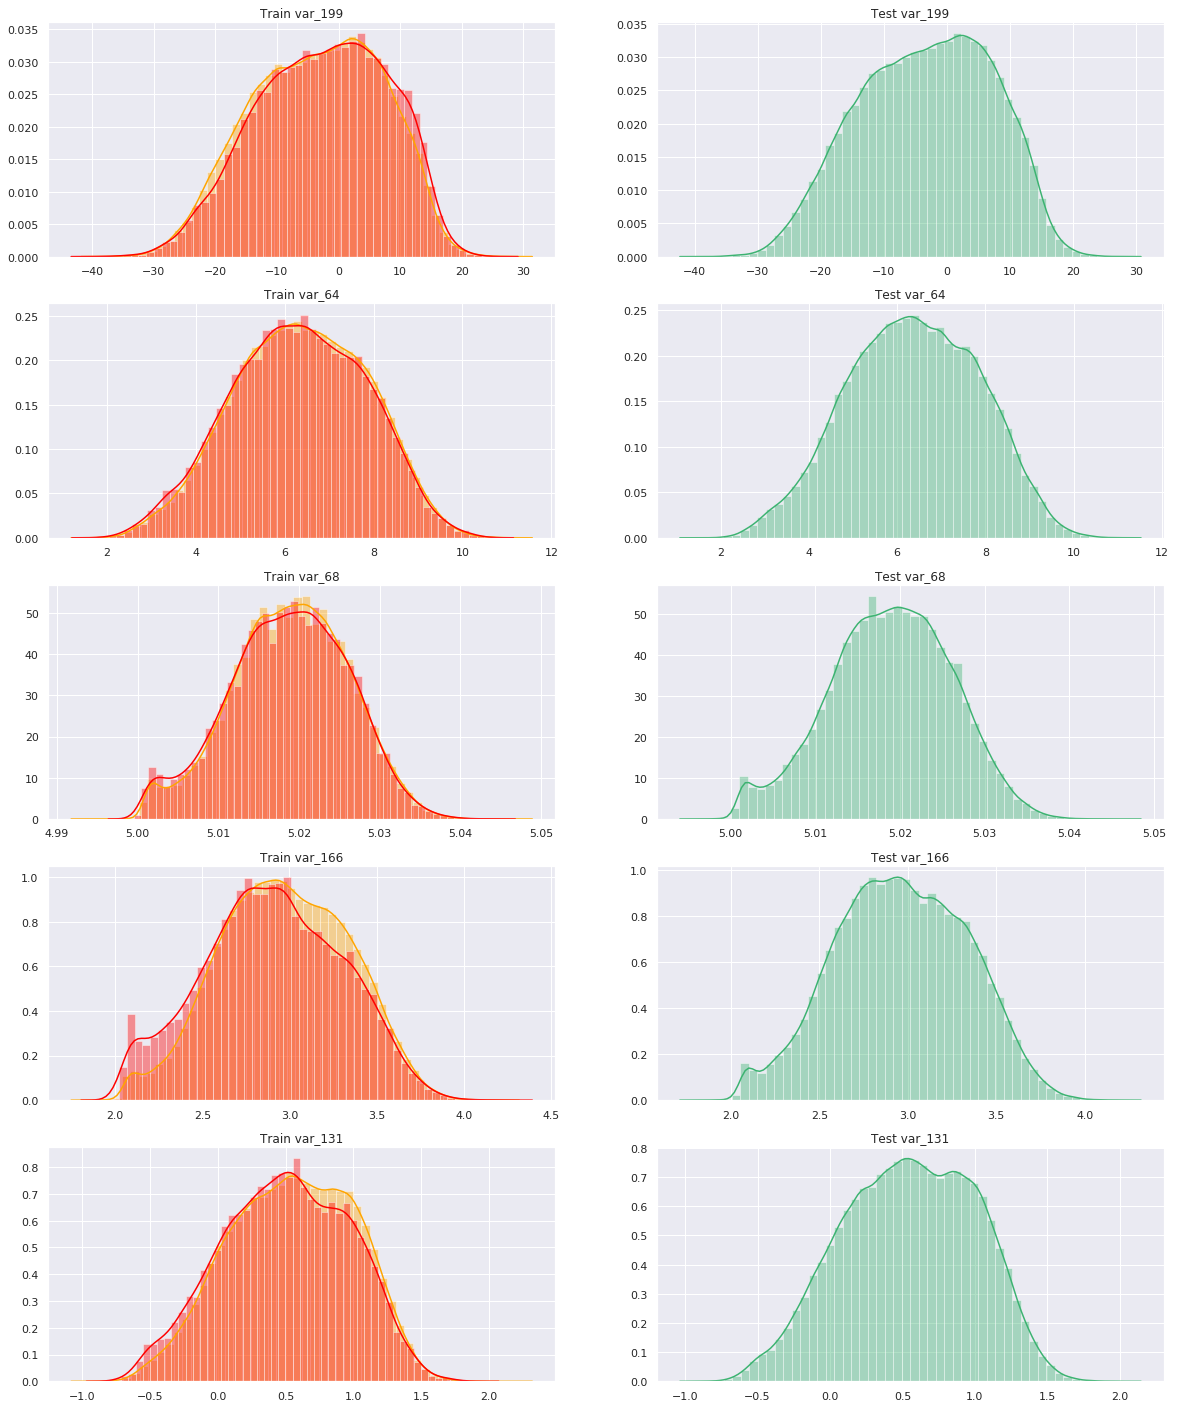

In [41]:
fig, ax = plt.subplots(n_top,2,figsize=(20,5*n_top))
feature_names = df_train.drop(['target'], axis=1).columns.values
for n in range(n_top):
    sns.distplot(df_train.loc[df_train.target==0, feature_names[top_features_idx][n]], ax=ax[n,0], color="Orange", norm_hist=True)
    sns.distplot(df_train.loc[df_train.target==1, feature_names[top_features_idx][n]], ax=ax[n,0], color="Red", norm_hist=True)
    sns.distplot(df_test.loc[:, feature_names[top_features_idx][n]], ax=ax[n,1], color="Mediumseagreen", norm_hist=True)
    ax[n,0].set_title("Train {}".format(feature_names[top_features_idx][n]))
    ax[n,1].set_title("Test {}".format(feature_names[top_features_idx][n]))
    ax[n,0].set_xlabel("")
    ax[n,1].set_xlabel("")

In [42]:
top = df_train.loc[:, feature_names[top_features_idx]]
top.describe()

,var_199,var_64,var_68,var_166,var_131
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-3.326537,6.369157,5.018893,2.963335,0.544674
std,10.438015,1.485854,0.007186,0.369684,0.456280
min,-38.852800,1.611700,4.993800,1.851200,-0.954800
25%,-11.208475,5.293500,5.014000,2.699000,0.207800
50%,-2.819550,6.377700,5.019100,2.960200,0.556600
75%,4.836800,7.490600,5.024100,3.241500,0.901000
max,28.500700,11.153700,5.046900,4.220400,2.192300


/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


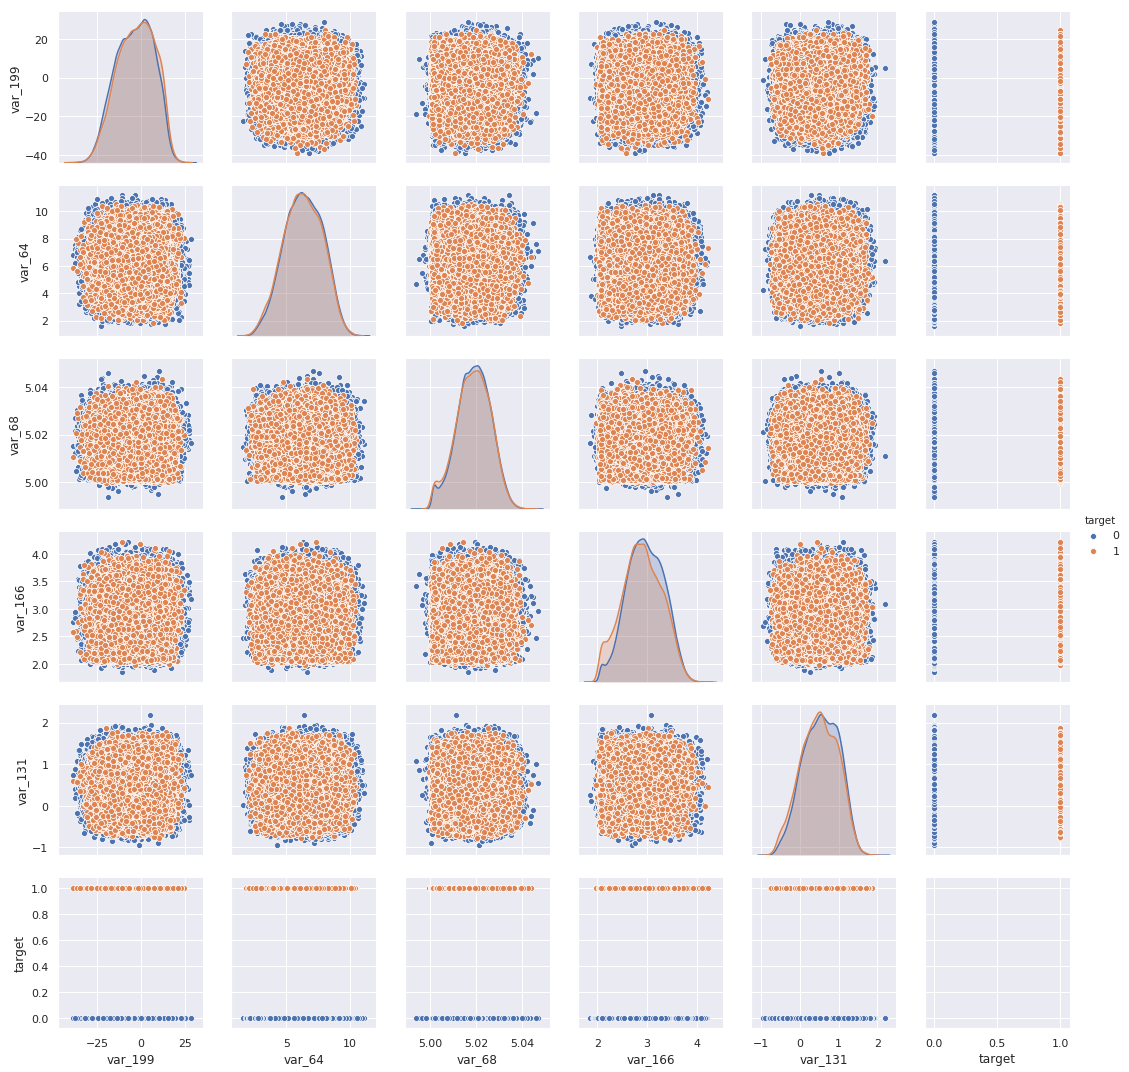

In [43]:
top = top.join(df_train.target)
sns.pairplot(top, hue="target")

In [67]:
sub_df = pd.DataFrame({'ID_code': df_test['ID_code'].values})
sub_df['target'] = model.predict(X_kaggle_test)
sub_df.to_csv('submission.csv', index=False)